<a href="https://colab.research.google.com/github/Loah-Lee/Blog/blob/main/%EB%AF%B8%EC%85%983_2%ED%8C%80_%EC%9D%B4%EC%86%8C%EC%9C%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 자전거 대여 패턴 분석

## ✅ 목표

이번 미션에서는 [자전거 대여 시스템 데이터]를 분석하여 자전거 배치 및 운영 전략을 최적화하고,

**대여 수요를 정확히 예측**하여 시스템의 효율성을 높이고 사용자 만족도를 증가시키는 방법을 찾는 것을 목표로 합니다.

먼저 데이터를 살펴보겠습니다.

In [3]:
# ✅ Colab: 한글 폰트 설치 & 등록 & 설정 (매 세션 1회)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')

# 1) 나눔고딕 설치
!apt-get -qq -y install fonts-nanum > /dev/null

# 2) 폰트 등록 & 전역 설정
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
from pathlib import Path

# 나눔 폰트 경로(Colab 표준 설치 위치)
nanum_dir = Path("/usr/share/fonts/truetype/nanum")

# 설치된 모든 나눔 TTF를 등록 (Regular/Bold/ExtraBold 등)
for fp in nanum_dir.glob("*.ttf"):
    fm.fontManager.addfont(str(fp))

# 폰트 패밀리 이름을 'NanumGothic'으로 지정
rcParams['font.family'] = 'NanumGothic'
rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지


In [5]:
import pandas as pd

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


| 컬럼명 | 데이터 타입 | 설명 |
|:--------|:--------------|:------------------------------------------------|
| datetime | datetime | 자전거 대여 기록의 날짜 및 시간. 예시: 2011-01-01 00:00:00 |
| season | int | 계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울) |
| holiday | int | 공휴일 여부 (0: 평일, 1: 공휴일) |
| workingday | int | 근무일 여부 (0: 주말/공휴일, 1: 근무일) |
| weather | int | 날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설) |
| temp | float | 실측 온도 (섭씨) |
| atemp | float | 체감 온도 (섭씨) |
| humidity | int | 습도 (%) |
| windspeed | float | 풍속 (m/s) |
| casual | int | 등록되지 않은 사용자의 대여 수 |
| registered | int | 등록된 사용자의 대여 수 |
| count | int | 총 대여 수 (종속 변수) |


## 1. 데이터 전처리

결측치, 중복치, 이상치 확인 후 처리할게요.

In [7]:
# 결측치, 중복치 확인 -> 없음
train.info()
print(train.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
0


In [8]:
# 이상치 확인
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


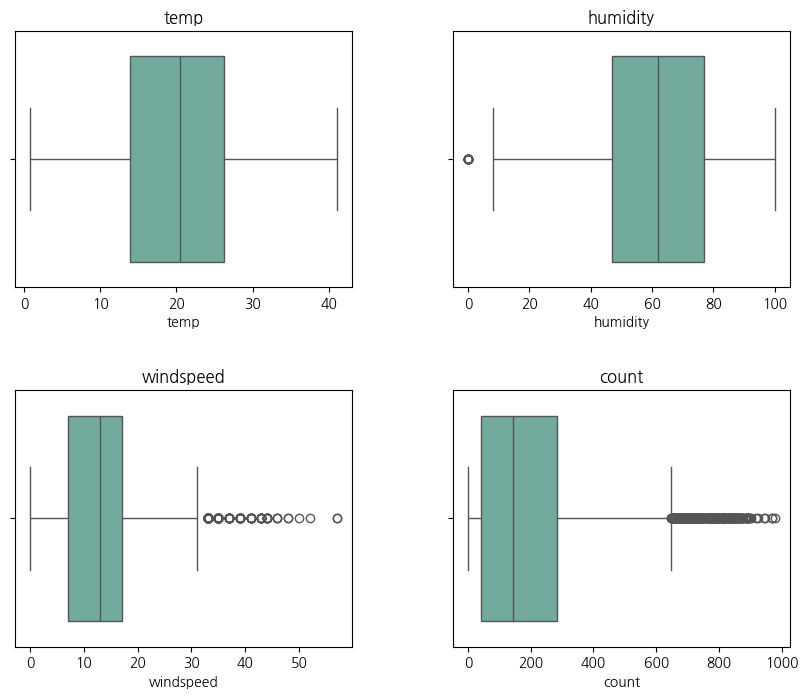

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['temp', 'humidity', 'windspeed', 'count']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, col in enumerate(numeric_cols):
    row = i // 2
    col_idx = i % 2
    sns.boxplot(x=train[col], ax=axes[row, col_idx], color="#69b3a2")
    axes[row, col_idx].set_title(col, fontsize=12)

plt.show()


humidity는 0일 수 없으므로, 이 이상치는 삭제하겠습니다.

windspeed와 count의 이상치는 의미있는 이상치일 수 있으므로 일단 남겨둘게요.

In [10]:
print("humidity가 0인 행 수:", (train['humidity'] == 0).sum())

# humidity 이상치 확인 후, 많지 않으므로 행 삭제
train = train[train['humidity'] != 0]

humidity가 0인 행 수: 22


## 2. 가설 세우기

컬럼에는 날짜, 계절, 날씨 등의 요인이 있는데요.

일반적으로 자전거를 타는 경우는 출퇴근 / 나들이 용도가 많죠?

혹은 차로 가기 애매한 거리를 자전거로 가는 경우도 많습니다.

즉, 시간대와 휴일 여부에 따라 대여량 차이가 클 것으로 예상됩니다.

물론 날씨의 영향도 클 것이구요.

데이터를 한번 살펴보며 아래의 가설을 검증해볼게요!

- *가설 1) 평일 출퇴근 시간대 등 특정 시간대에 대여량이 많을 것이다.*
- *가설 2) 날씨가 좋을 때 대여량이 많을 것이다. (온도, 풍속, 눈비)*

## 3. 가설 검증

### 3-1. *가설 1) 평일 출퇴근 시간대 등 특정 시간대에 대여량이 많을 것이다* ?

이제 데이터 시각화를 통해 하나씩 살펴볼게요!

우선 시간대를 파악하기 위해 관련 컬럼 'datetime' 을  세분화하겠습니다.

In [12]:
# datetime 타입 처리
train['datetime'] = pd.to_datetime(train['datetime'], errors='coerce')

train['year']   = train['datetime'].dt.year
train['month']  = train['datetime'].dt.month
train['day']    = train['datetime'].dt.day
train['hour']   = train['datetime'].dt.hour

이제 각 특성(컬럼)별 전체 데이터를 보고, 특성을 파악해볼게요.

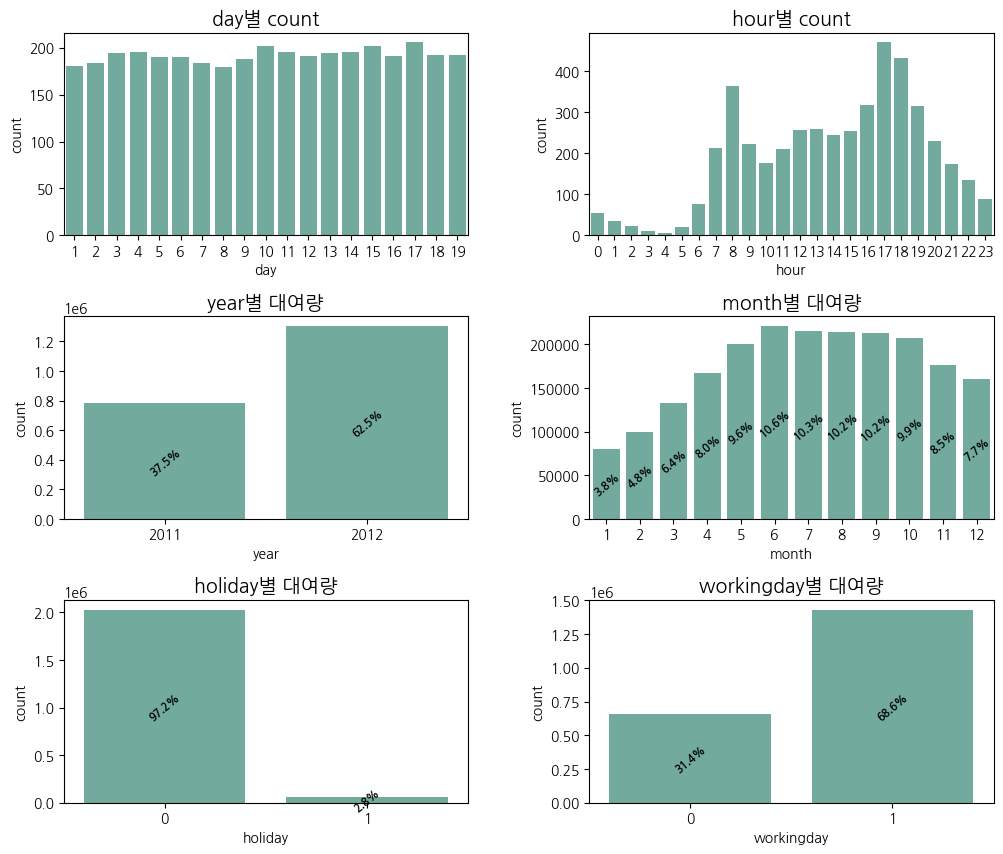

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

time_cols = ['day', 'hour', 'year', 'month', 'holiday', 'workingday']
ratio_cols = ['year', 'month', 'holiday', 'workingday']  # 비율 표시할 컬럼만

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, col in enumerate(time_cols):
    row, col_idx = divmod(i, 2)
    ax = axes[row, col_idx]

    # 1) 그룹별 총 대여량 집계 및 정렬
    group_df = (
        train.groupby(col, as_index=False)['count']
             .sum()
             .sort_values(col)
    )

    if col in ratio_cols:
        # 2) 전체 대비 비율 계산(%)
        group_df['ratio'] = group_df['count'] / group_df['count'].sum() * 100

        # 3) x축 순서 고정 (seaborn이 내부에서 재정렬하지 않도록)
        x_order = group_df[col].tolist()

        # 4) barplot (y축은 count), 텍스트는 ratio(%)
        sns.barplot(x=col, y='count', data=group_df, order=x_order,
                    ax=ax, color="#69b3a2", errorbar=None)
        ax.set_title(f"{col}별 대여량", fontsize=14)
        ax.set_ylabel("count")

        # 5) 막대 '중앙'에 비율(%) 표시 — 값은 ratio에서 가져오기!
        for patch, pct in zip(ax.patches, group_df['ratio'].to_numpy()):
            ax.text(
                patch.get_x() + patch.get_width()/2,
                patch.get_height()/2,            # 중앙 위치
                f"{pct:.1f}%",
                ha="center", va="center",
                fontsize=8, rotation=40, color="black", fontweight="bold"
            )
    else:
        # day, hour는 평균 대여량 표시 (원래 의도 유지)
        sns.barplot(x=col, y='count', data=train, ax=ax,
                    color="#69b3a2", errorbar=None)
        ax.set_title(f"{col}별 count", fontsize=14)
        ax.set_ylabel("count")

plt.show()


| 컬럼명 | 데이터 타입 | 설명 |
|:--------|:--------------|:------------------------------------------------|
| holiday | int | 공휴일 여부 (0: 평일, 1: 공휴일) |
| workingday | int | 근무일 여부 (0: 주말/공휴일, 1: 근무일) |

[holiday, workingday]

평일, 근무일에 대여량이 월등히 많네요!


[hour]

그리고 특정 시간대(8시 to 9시, 17시 to 19시)에 대여량이 많음을 알 수 있는데, 이건 딱 출퇴근 시간대이군요. 가설 1번이 맞았습니다.

[year]

또한 2012년에 자전거 대여량이 확 늘었습니다.

2012년에 무슨 정책적 변화가 있던 것인지, 자전거 대여 플랫폼이 유행을 탄것인지 등 추가 조사를 해보면 좋겠네요.


[month]

11월 -> 4월 사이에는 대여량이 줄었다가 다시 회복됨을 볼 수 있습니다. 이는 추운 날씨 때문일 것으로 예상되는데요, 가설 2번에서 더 자세히 살펴볼게요.


### 3-2. *가설 2) 날씨가 좋을 때 대여량이 많을 것이다.* ?

이번에는 날씨 특성(온도, 습도, 눈/비)에 따라 대여량 차이가 어떻게 나는지 볼게요.

먼저 이산형 데이터를 막대그래프로 보겠습니다.

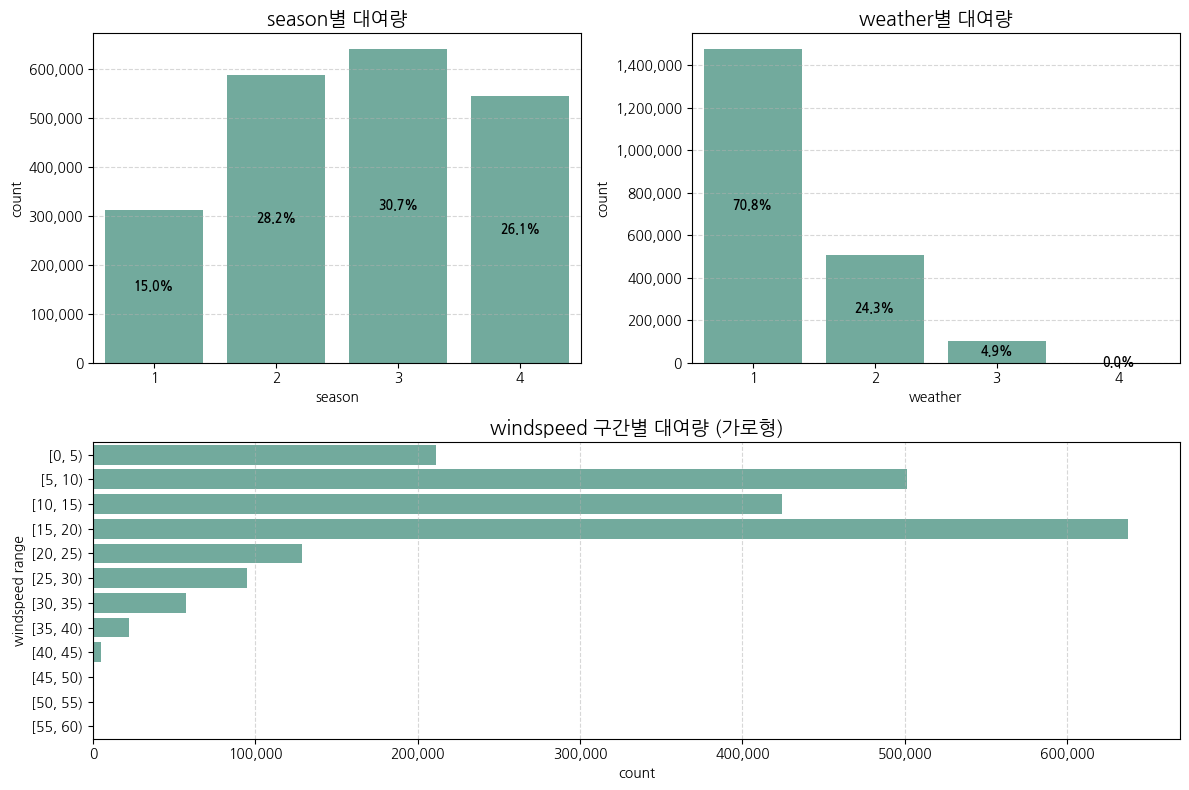

In [14]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --------- 상단 2개: season, weather ---------
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.9])

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, :])   # windspeed (가로형)
]

# --------- 1) season & weather (세로형 + 비율표시 + 점선 그리드) ---------
for ax, col in zip(axes[:2], ['season', 'weather']):
    group_df = (
        train.groupby(col, as_index=False)['count']
             .sum()
             .sort_values(col)
    )
    group_df['ratio'] = group_df['count'] / group_df['count'].sum() * 100
    x_order = group_df[col].tolist()

    sns.barplot(x=col, y='count', data=group_df, order=x_order,
                ax=ax, color="#69b3a2", errorbar=None)
    ax.set_title(f"{col}별 대여량", fontsize=14)
    ax.set_ylabel("count")

    # ✅ y축 숫자 형식: 과학적 표기 제거 + 콤마 추가
    ax.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

    # ✅ 배경 점선 추가
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # ✅ 막대 중앙에 비율(%) 표시
    for patch, pct in zip(ax.patches, group_df['ratio'].to_numpy()):
        ax.text(
            patch.get_x() + patch.get_width()/2,
            patch.get_height()/2,
            f"{pct:.1f}%",
            ha="center", va="center",
            fontsize=9, color="black", fontweight="bold"
        )

# --------- 2) windspeed (가로형 + 점선 그리드, 비율표시 없음) ---------
ax = axes[2]

max_ws = int(math.ceil(train['windspeed'].max() / 5.0) * 5)
bins = list(range(0, max_ws + 5, 5))
train['_windspeed_bin'] = pd.cut(train['windspeed'], bins=bins, right=False)

ws_df = (
    train.groupby('_windspeed_bin', as_index=False, observed=False)['count']
         .sum()
         .sort_values('_windspeed_bin')
)

sns.barplot(y='_windspeed_bin', x='count', data=ws_df, ax=ax,
            orient='h', color="#69b3a2", errorbar=None)
ax.set_title("windspeed 구간별 대여량 (가로형)", fontsize=14)
ax.set_xlabel("count")
ax.set_ylabel("windspeed range")

# ✅ x축 숫자 형식 & 배경 점선
ax.ticklabel_format(style='plain', axis='x')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# (정리) 임시 컬럼 삭제
del train['_windspeed_bin']

| 컬럼명 | 데이터 타입 | 설명 |
|:--------|:--------------|:------------------------------------------------|
| season | int | 계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울) |
| weather | int | 날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설) |
| windspeed | float | 풍속 (m/s) |

[season]

가을에 가장 많이 빌리고, 의외로 겨울이 아닌 봄에 자전거를 가장 안빌리는군요!

봄에서 여름을 넘어가며 대여량이 급격히 늘어난 것이 가장 유의미해 보입니다.

[weather]

역시나 맑은 날씨에 압도적으로 대여량이 높고, 폭우/폭설에는 0 입니다.


[windspeed]

풍속이 쎄지 않을 때가 대여량이 월등히 많네요! 풍속이 영향을 많이 끼치는 것으로 확인했습니다.

| 컬럼명 | 데이터 타입 | 설명 |
|:--------|:--------------|:------------------------------------------------|
| temp | float | 실측 온도 (섭씨) |
| atemp | float | 체감 온도 (섭씨) |
| humidity | int | 습도 (%)

이제 연속형 데이터를 산점도로 시각화 해볼게요!

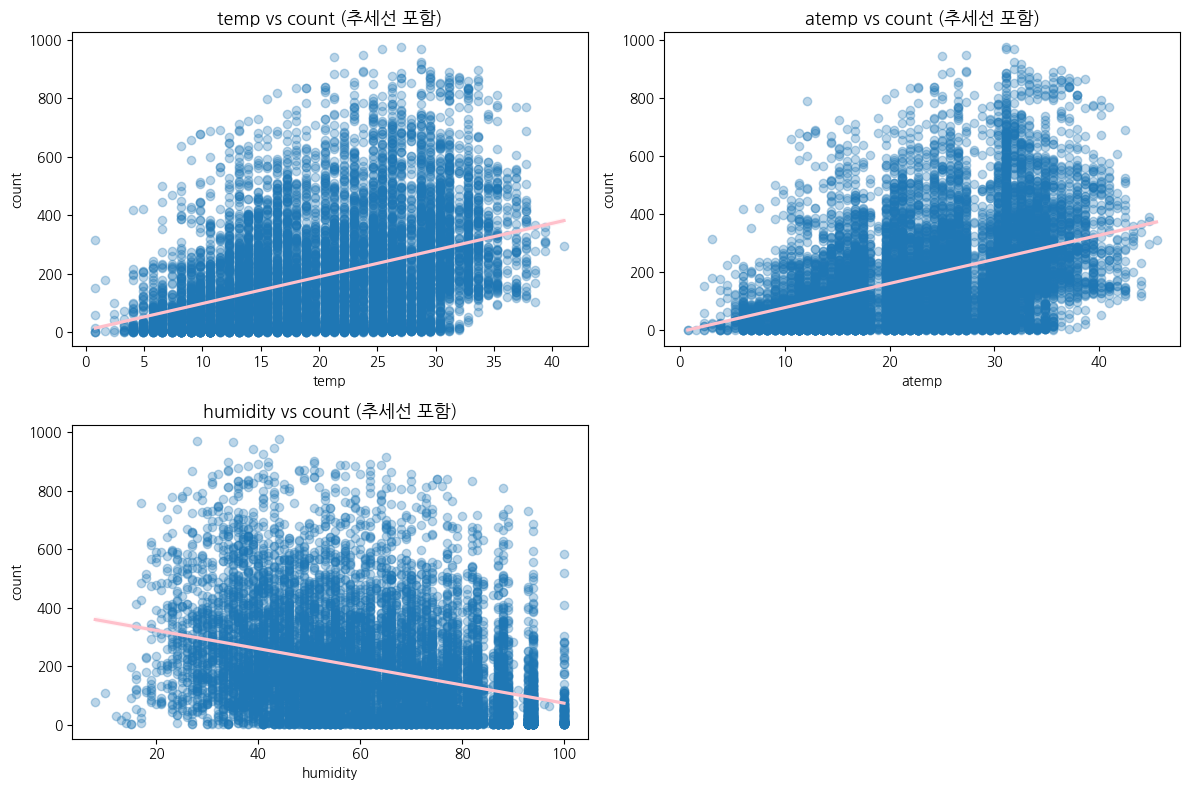

In [15]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

weather_features = ['temp', 'atemp', 'humidity']   # 변수 개수에 맞춰 자동
n = len(weather_features)
cols_per_row = 2
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(12, rows * 4))
axes = axes.flatten()

for i, col in enumerate(weather_features):
    sns.regplot(x=col, y='count', data=train,
                scatter_kws={'alpha':0.3}, line_kws={'color':'pink'}, ax=axes[i])
    axes[i].set_title(f"{col} vs count (추세선 포함)", fontsize=13)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("count")

# 남은 칸 있으면 숨기기
for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
# 상관관계 수치화
print(train[['temp', 'count']].corr().iloc[0,1])
print(train[['atemp', 'count']].corr().iloc[0,1])
print(train[['humidity', 'count']].corr().iloc[0,1])

0.3938926637293181
0.38926858402708947
-0.326955697578108


[temp, atemp]

둘은 비슷한 양상을 보이는데요! 결국 온도가 높아질수록(더워질수록) 대여량이 많아짐을 확인할 수 있습니다.

[humidity]

습도는 높을수록 대여량이 낮네요! 습할 때는 밖에 있는 것조차 싫어하기 때문이겠죠?

세 데이터 모두 상관관계가 확실하게 보입니다. 즉, 날씨 변화에 따른 대여량 추이가 상당합니다.

이제 지금까지 한 EDA를 토대로 자전거 대여량 예측 모델을 만들어볼게요!

목표 변수인 count가 수치혀 데이터이므로, **선형 회귀** 방식으로 모델을 학습시키겠습니다.

### 3-3. 정리

- [holiday, workingday]

평일, 근무일에 대여량이 월등히 많았습니다.

- [hour]

특정 시간대(출퇴근 시간대)에 대여량이 많았습니다.

- [year]

2011년 대비 2012년에 자전거 대여량이 확 늘었습니다.

- [month], [season]

11월과 4월 사이(겨울, 봄)에는 대여량이 줄었다가 다시 회복되었으며 가을에 가장 대여량이 많았어요.

봄에서 여름을 넘어가며 대여량이 급격히 늘어난 것도 유의미해 보입니다.

- [weather]

역시나 맑은 날씨에 압도적으로 대여량이 높고, 폭우/폭설에는 0 입니다.

- [windspeed]

풍속이 쎄지 않을 때가 대여량이 월등히 많았습니다.

- [temp, atemp]

온도가 높아질수록(더워질수록) 대여량이 많아짐을 확인할 수 있었습니다.

- [humidity]

습도는 높을수록 대여량이 낮았습니다.

## 4. 모델 학습

이제 지금까지 했더 EDA를 토대로 모델을 학습시키고, test 데이터로 성능을 평가할게요!

목표 변수 count가 수치형 데이터이기 때문에, **선형 회귀** 방식으로 학습시키겠습니다.



### 4-1. 선형 회귀 학습

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# datetime 삭제 (회귀모델 입력 불가)
if 'datetime' in train.columns:
    train = train.drop(columns=['datetime'])

# 입력변수(X), 목표변수(y) 설정
feature_cols = [
    'season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed',
    'year', 'month', 'day', 'hour', 'holiday', 'workingday'
]

X = train[feature_cols]
y = train['count']

# train/test 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 범주형 변수 인코딩 (dummy 변환)
cat_cols = ['season', 'weather', 'month', 'day', 'hour', 'holiday', 'workingday']
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_val  = pd.get_dummies(X_val,  columns=cat_cols, drop_first=True)

# 열 개수 맞추기 (train/test 불일치 방지)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

# 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

자, 이제 이 모델의 성능을 평가해야합니다. 이 모델의 RMSLE를 측정하여 최대한 낮추는 것이 목표입니다!

평가해볼게요.

✅ RMSLE: 1.0806


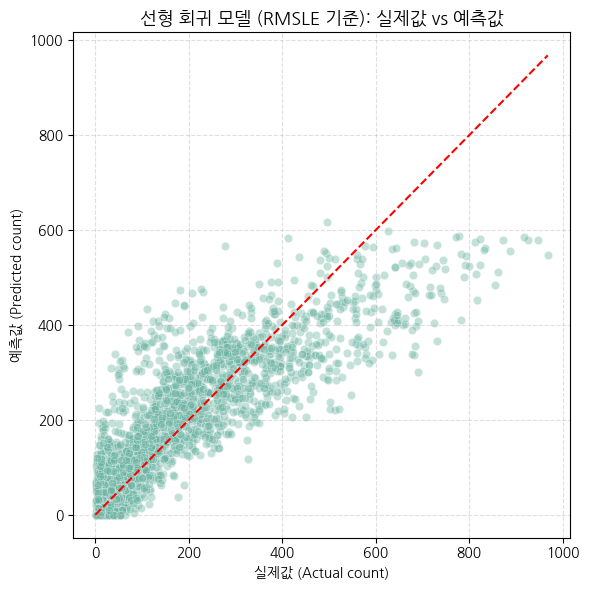

In [19]:
# ✅ 예측
y_pred = model.predict(X_val)

# 음수값 방지 (log 계산 시 에러 방지)
y_pred = np.where(y_pred < 0, 0, y_pred)

# ✅ RMSLE 계산
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"✅ RMSLE: {rmsle:.4f}")

# ✅ 실제값 vs 예측값 시각화
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.4, color="#69b3a2")
plt.plot([0, y_val.max()], [0, y_val.max()], color='red', linestyle='--')
plt.xlabel("실제값 (Actual count)")
plt.ylabel("예측값 (Predicted count)")
plt.title("선형 회귀 모델 (RMSLE 기준): 실제값 vs 예측값", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


음... 개선이 필요하네요. 데이터의 분포상 로그를 입히면 좋을 것 같습니다.

✅ RMSLE: 1.0806


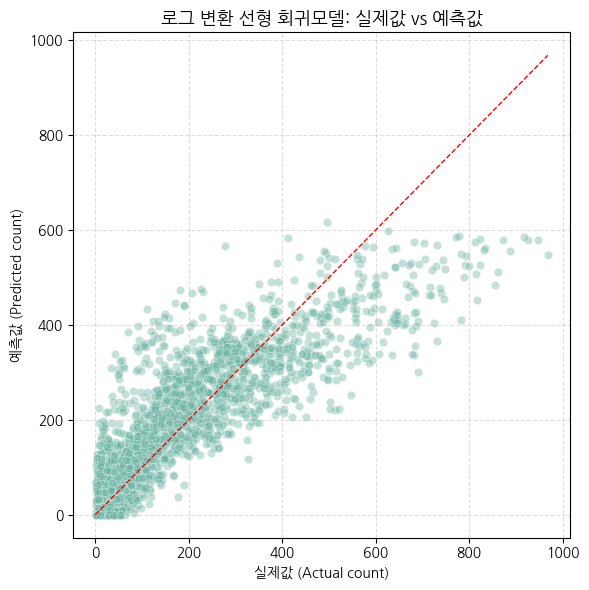

In [20]:
# 로그 변환
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# RMSLE 계산
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"✅ RMSLE: {rmsle:.4f}")

# 실제값 vs 예측값 시각화
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.4, color="#69b3a2")
plt.plot([0, y_val.max()], [0, y_val.max()], color='red', linestyle='--', linewidth=1)
plt.xlabel("실제값 (Actual count)")
plt.ylabel("예측값 (Predicted count)")
plt.title("로그 변환 선형 회귀모델: 실제값 vs 예측값", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


✅ RMSLE: 0.5947


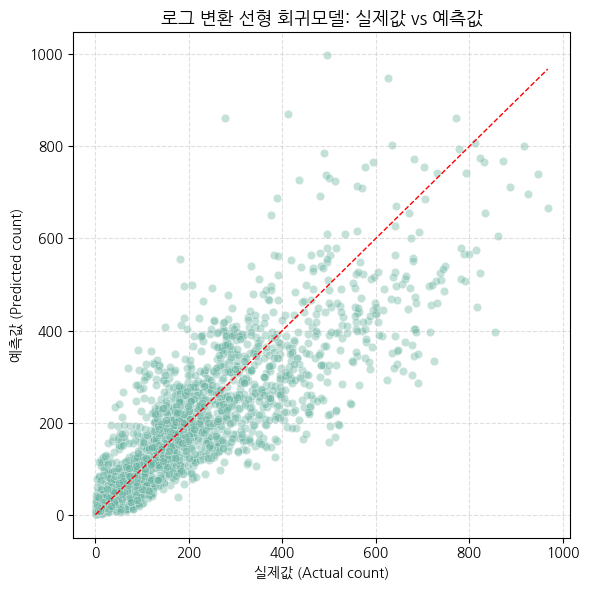

In [23]:
# 로그 변환된 타깃으로 학습
y_train_log = np.log1p(y_train)   # log(y + 1)
model = LinearRegression()
model.fit(X_train, y_train_log)

# 예측 (로그 스케일에서 예측 후 되돌림)
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)     # exp(pred) - 1

# 음수 예측값 보정 (log 계산 시 에러 방지)
y_pred = np.where(y_pred < 0, 0, y_pred)

# RMSLE 계산
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))

print(f"✅ RMSLE: {rmsle:.4f}")

# 실제값 vs 예측값 시각화
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.4, color="#69b3a2")
plt.plot([0, y_val.max()], [0, y_val.max()], color='red', linestyle='--', linewidth=1)
plt.xlabel("실제값 (Actual count)")
plt.ylabel("예측값 (Predicted count)")
plt.title("로그 변환 선형 회귀모델: 실제값 vs 예측값", fontsize=13)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


오 RMSLE 수치가 거의 절반 낮아졌습니다! 이 정도면 보통은 하겠군요..!

여기서 더 줄이기 위해서는 다른 모델들도 실험해보면 좋을 것 같습니다.

(시간대, 날씨의 영향을 받는 특성에 따라 결정트리 기법을 활용하면 좋을 것 같아요.)

## 운영 전략 제안

지금까지 분석한 결과를 토대로 자전거 대여 수요가 많은 **날씨 특성, 시간대**에 맞춰 자전거가 적재적소에 공급될 수 있도록 운영안을 짜야겠군요!

그러려면 **출퇴근 시간대에 자전거가 출발하는 위치 / 도착하는 위치에 대한 데이터**가 추가적으로 파악되면 좋겠습니다.